## 实验目的
这个实验的目的是检测直方图均衡对各个hls各个通道的影像
包括分别均衡化、均衡化某一个通道转到rgb空间再转回来

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
%matplotlib inline

In [2]:
names = glob.glob('ML10/*.jpg')
print(sorted(names))

['ML10/patch0.jpg', 'ML10/patch1.jpg', 'ML10/patch10.jpg', 'ML10/patch11.jpg', 'ML10/patch12.jpg', 'ML10/patch13.jpg', 'ML10/patch14.jpg', 'ML10/patch15.jpg', 'ML10/patch16.jpg', 'ML10/patch17.jpg', 'ML10/patch18.jpg', 'ML10/patch19.jpg', 'ML10/patch2.jpg', 'ML10/patch20.jpg', 'ML10/patch21.jpg', 'ML10/patch22.jpg', 'ML10/patch23.jpg', 'ML10/patch24.jpg', 'ML10/patch25.jpg', 'ML10/patch26.jpg', 'ML10/patch27.jpg', 'ML10/patch28.jpg', 'ML10/patch29.jpg', 'ML10/patch3.jpg', 'ML10/patch30.jpg', 'ML10/patch31.jpg', 'ML10/patch32.jpg', 'ML10/patch33.jpg', 'ML10/patch34.jpg', 'ML10/patch35.jpg', 'ML10/patch36.jpg', 'ML10/patch37.jpg', 'ML10/patch38.jpg', 'ML10/patch39.jpg', 'ML10/patch4.jpg', 'ML10/patch5.jpg', 'ML10/patch6.jpg', 'ML10/patch7.jpg', 'ML10/patch8.jpg', 'ML10/patch9.jpg']


In [3]:
# Sobel Operator
def abs_sobel_thresh( gray, orient='x', sobel_kernel=3, thresh=(20, 100)):
    if orient == 'x':
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel_ = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_so = np.absolute(sobel_)
    scaled_so = np.uint8(255 * abs_so / np.max(abs_so))
    result = np.zeros_like(scaled_so)
    result[(scaled_so >= thresh[0]) & (scaled_so <= thresh[1])] = 1
    return result

# Magnitude of the Gradient
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Direction of the Gradient
def dir_thresh(gray, sobel_kernel=3, dir_thresh=(0, np.pi / 2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    return binary_output

# 梯度阈值的集合
def get_gradient_thre(gray):
    ker_size = 9
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ker_size, thresh=(50, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ker_size, thresh=(50, 255))

    mag_bin = mag_thresh(gray, sobel_kernel=ker_size, mag_thresh=(70, 255))
    dir_bin = dir_thresh(gray, sobel_kernel=ker_size, dir_thresh=(0.7, 1.3))

    gradient = np.zeros_like(dir_bin)
    gradient[((gradx == 1) & (grady == 1)) | ((mag_bin == 1) & (dir_bin == 1))] = 1
    return gradient

In [4]:
def hls_select(img,l_thresh=(30,200),s_thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary_zero = np.zeros_like(l_channel)
    l_binary_zero[l_channel>l_thresh[1]] = 1
    
    l_binary_one = np.ones_like(l_channel)
    l_binary_one[l_channel<l_thresh[0]] = 0
    
    s_high = np.zeros_like(l_channel)
    s_high[(s_binary==1) | (l_binary_zero==1)] = 1
    s_high_low = np.zeros_like(l_channel)
    s_high_low[(s_high==1) & (l_binary_one==1)] = 1
    return s_high_low

Text(0.5, 0.9, 'source')

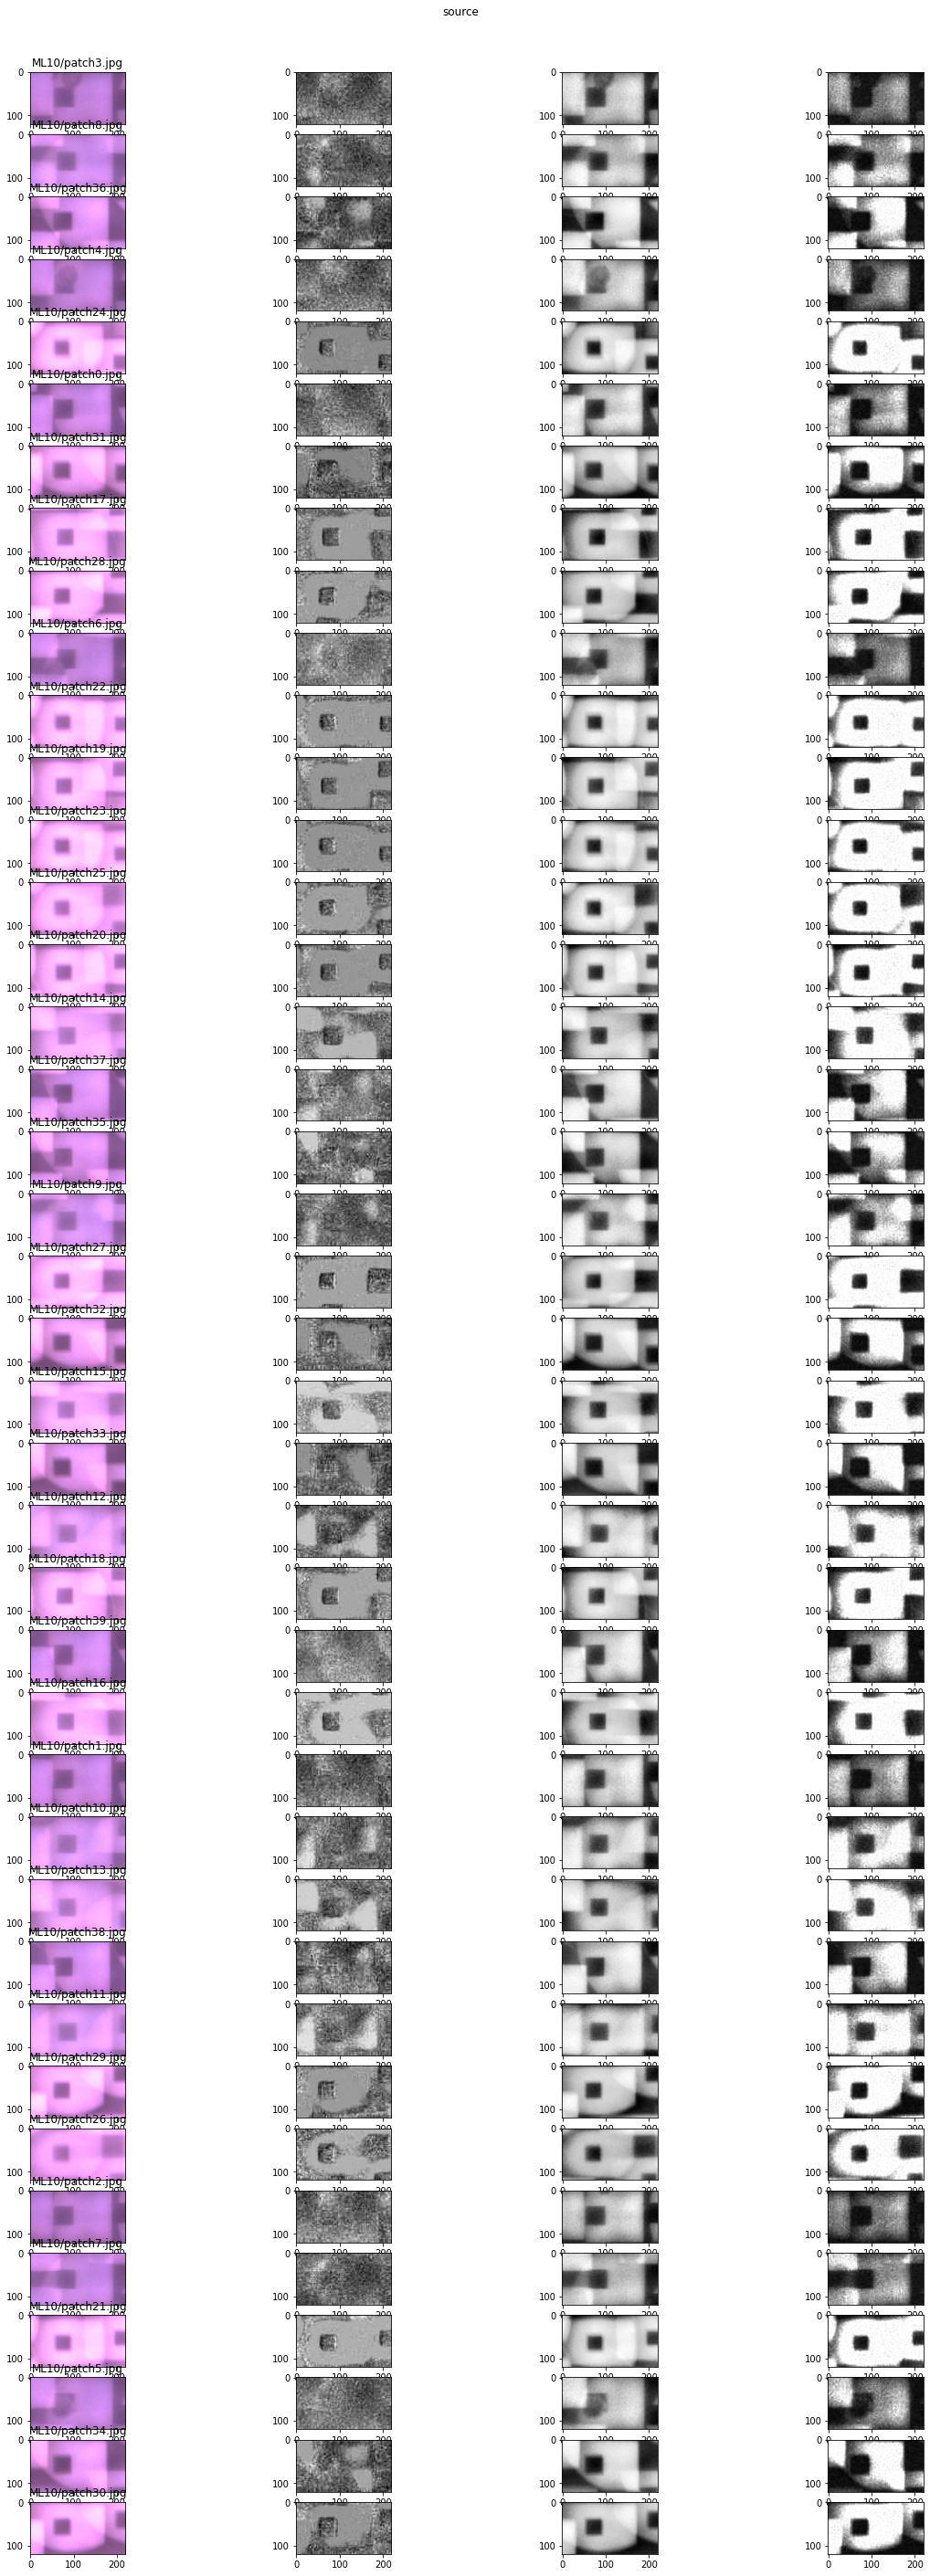

In [5]:
f, axes = plt.subplots(len(names),4,figsize=(20,50))
# plt.figure(figsize=(20,10))
for i in range(len(names)):
    img = mpimg.imread(names[i])
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    axes[i][0].imshow(img)
    axes[i][0].set_title(names[i])
    
    axes[i][1].imshow(hls[:,:,0],cmap='gray')
    axes[i][2].imshow(hls[:,:,1],cmap='gray')
    axes[i][3].imshow(hls[:,:,2],cmap='gray')
plt.tight_layout
f.suptitle('source',y=0.9)

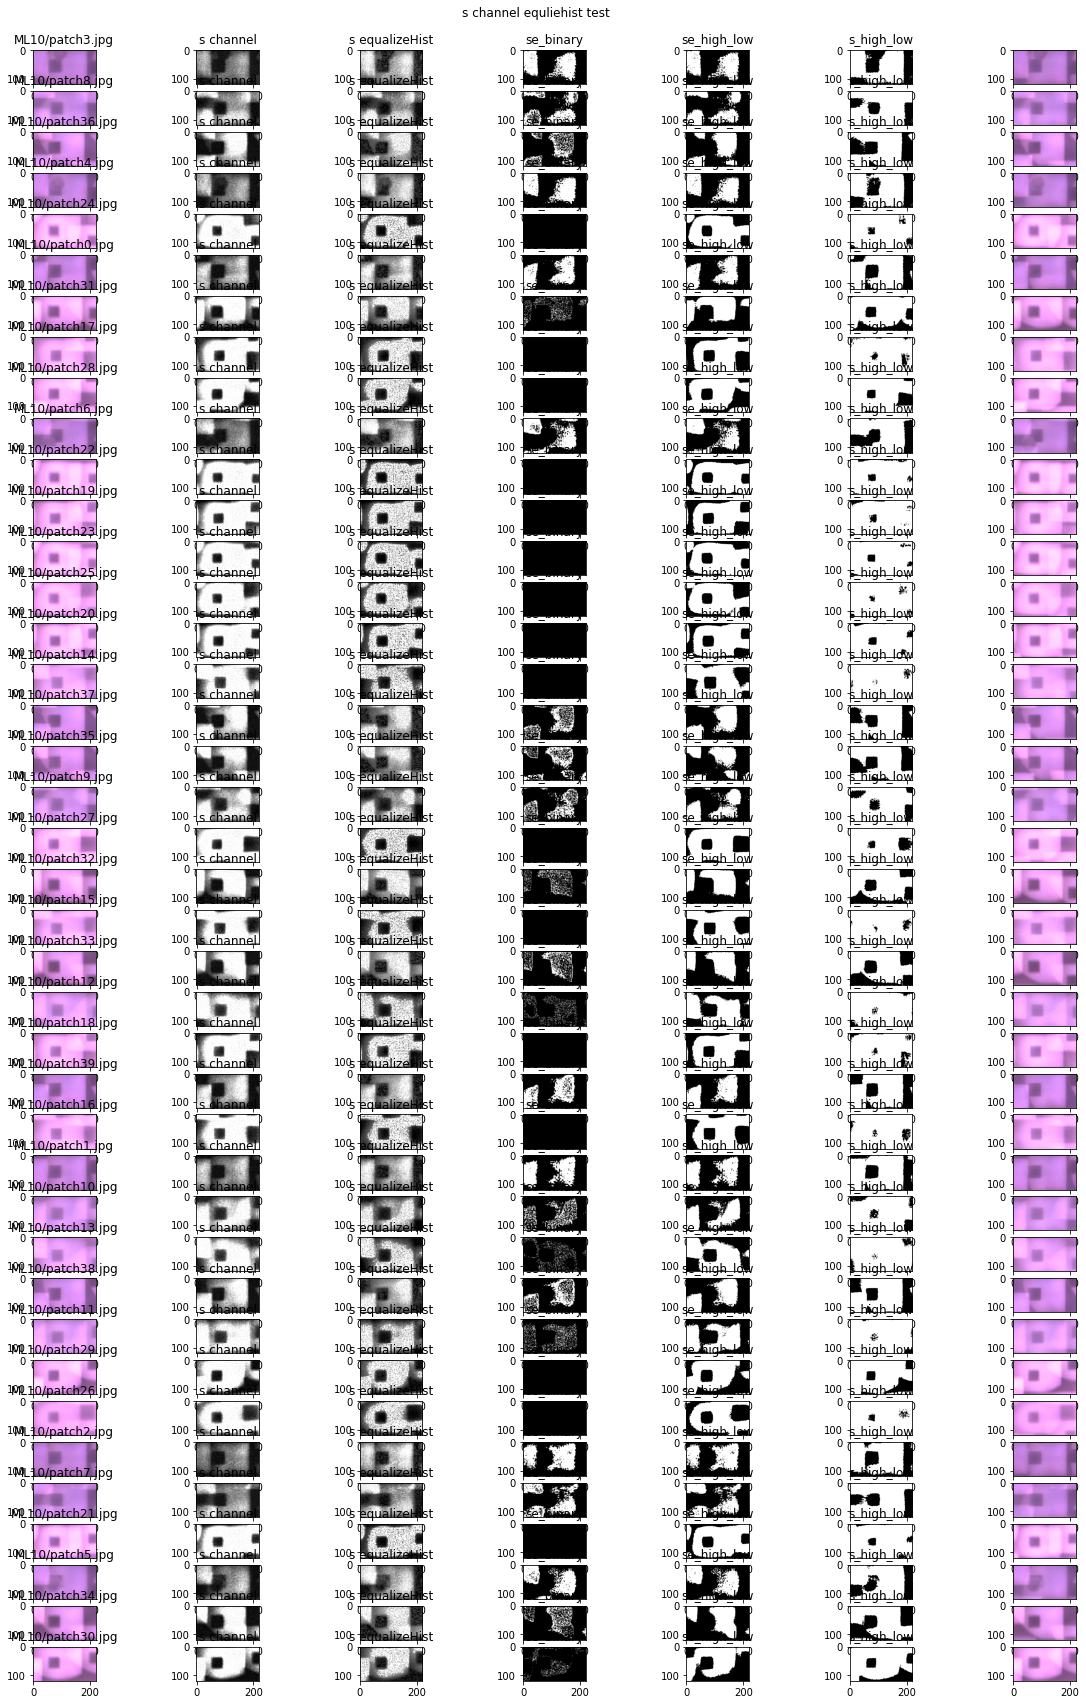

In [6]:
s_thresh = (165,255)
l_thresh = (30,200)
f, axes = plt.subplots(len(names),7,figsize=(20,30))
# plt.figure(figsize=(20,10))
for i in range(len(names)):
    img = mpimg.imread(names[i])
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_equ = cv2.equalizeHist(hls[:,:,2])
    
    s_bin = np.zeros_like(s_equ)
    s_bin[(s_equ>s_thresh[0])&(s_equ<s_thresh[1])] = 1
    
    l_binary_zero = np.zeros_like(l_channel)
    l_binary_zero[l_channel>l_thresh[1]] = 1
    
    l_binary_one = np.ones_like(l_channel)
    l_binary_one[l_channel<l_thresh[0]] = 0
    
    s_high = np.zeros_like(l_channel)
    s_high[(s_bin==1) | (l_binary_zero==1)] = 1
    se_high_low = np.zeros_like(l_channel)
    se_high_low[(s_high==1) & (l_binary_one==1)] = 1
    
    s_high_low = hls_select(img,(30,200),(90,255))
    
    axes[i][0].imshow(img)
    axes[i][0].set_title(names[i])
    
    axes[i][1].imshow(hls[:,:,2],cmap='gray')
    axes[i][1].set_title('s channel')
    
    axes[i][2].imshow(s_equ,cmap='gray')
    axes[i][2].set_title('s equalizeHist')
    
    axes[i][3].imshow(s_bin,cmap = 'gray')
    axes[i][3].set_title('se_binary')
    
    axes[i][4].imshow(se_high_low,cmap='gray')
    axes[i][4].set_title('se_high_low')
    
    axes[i][5].imshow(s_high_low,cmap='gray')
    axes[i][5].set_title('s_high_low')
    
    axes[i][6].imshow(img)
    
    
plt.tight_layout
plt.suptitle('s channel equliehist test',y=0.9)
plt.savefig('s_equlizehist测试165-255.jpg',dpi=500)

Text(0.5, 0.9, 'split s channel equ and feed to the other two channels')

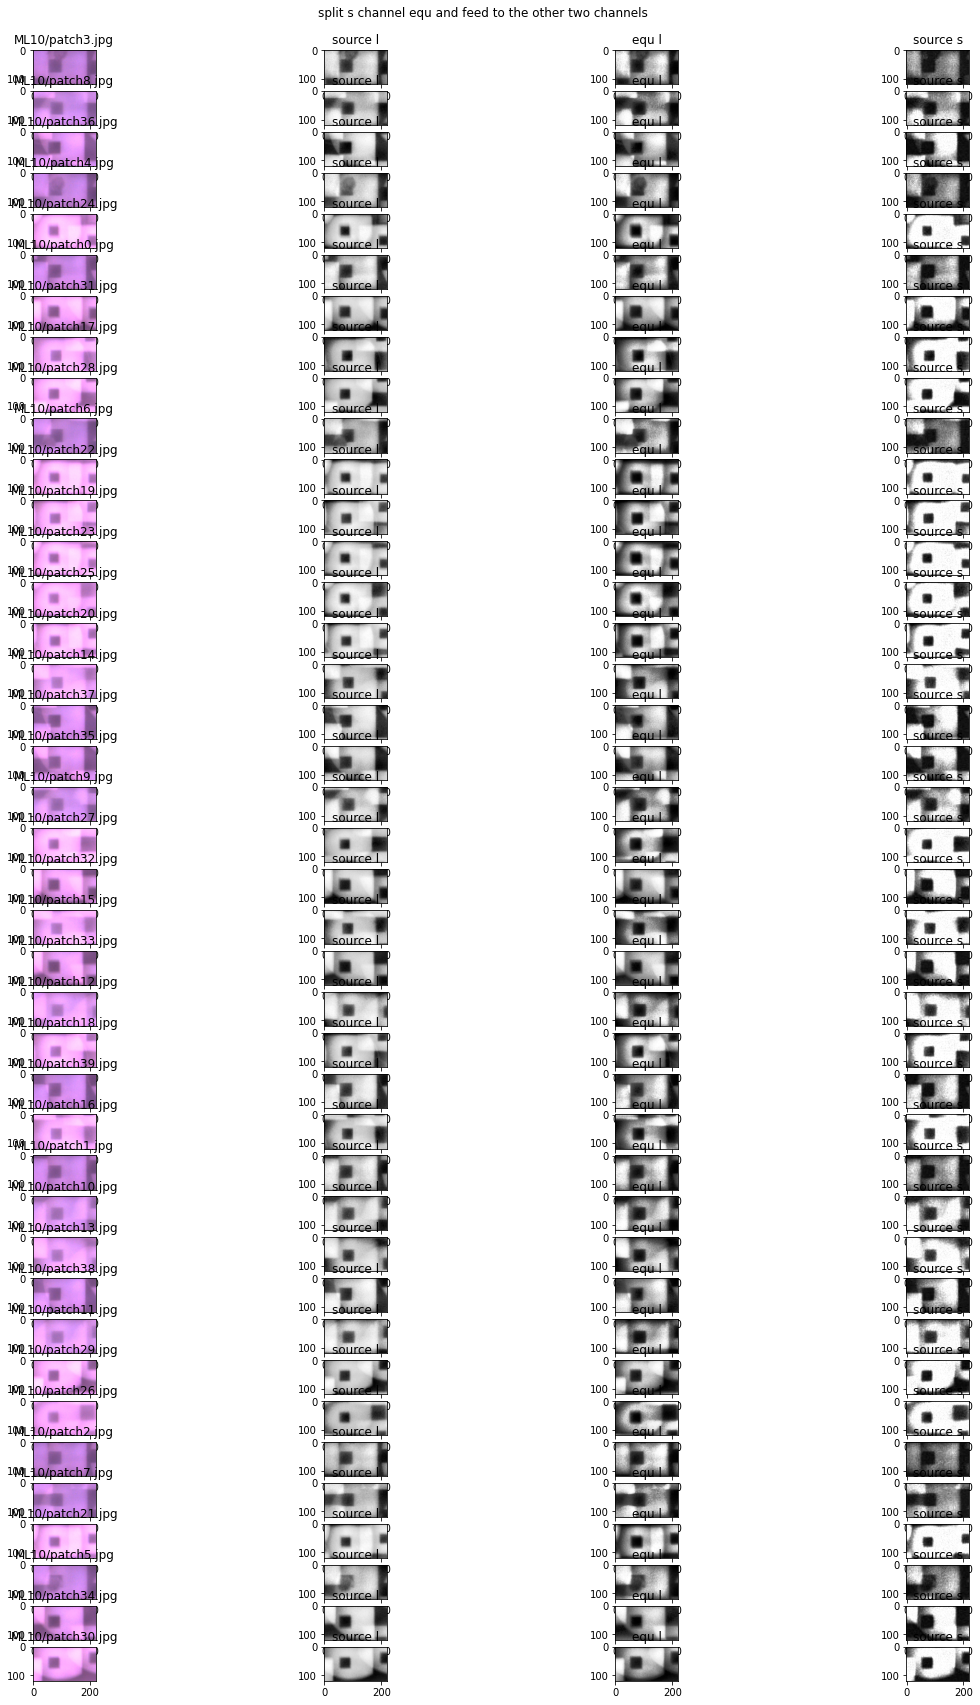

In [7]:
f, axes = plt.subplots(len(names),4,figsize=(20,30))
# plt.figure(figsize=(20,10))
for i in range(len(names)):
    img = mpimg.imread(names[i])
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    l_equ = cv2.equalizeHist(hls[:,:,1])
    
    axes[i][0].imshow(img)
    axes[i][0].set_title(names[i])
    
    axes[i][1].imshow(hls[:,:,1],cmap='gray')
    axes[i][1].set_title('source l')
    axes[i][2].imshow(l_equ,cmap='gray')
    axes[i][2].set_title('equ l')
    axes[i][3].imshow(hls[:,:,2],cmap='gray')
    axes[i][3].set_title('source s')
plt.tight_layout
plt.suptitle('split s channel equ and feed to the other two channels',y=0.9)

## 结论  s通道直方图均衡，hls_select设置为30，200，160，255可行

## 思路 利用l通道排除阴影，即像素值再某个阈值之下的，设置为0，同时l通道高于某个值的，也设置为1

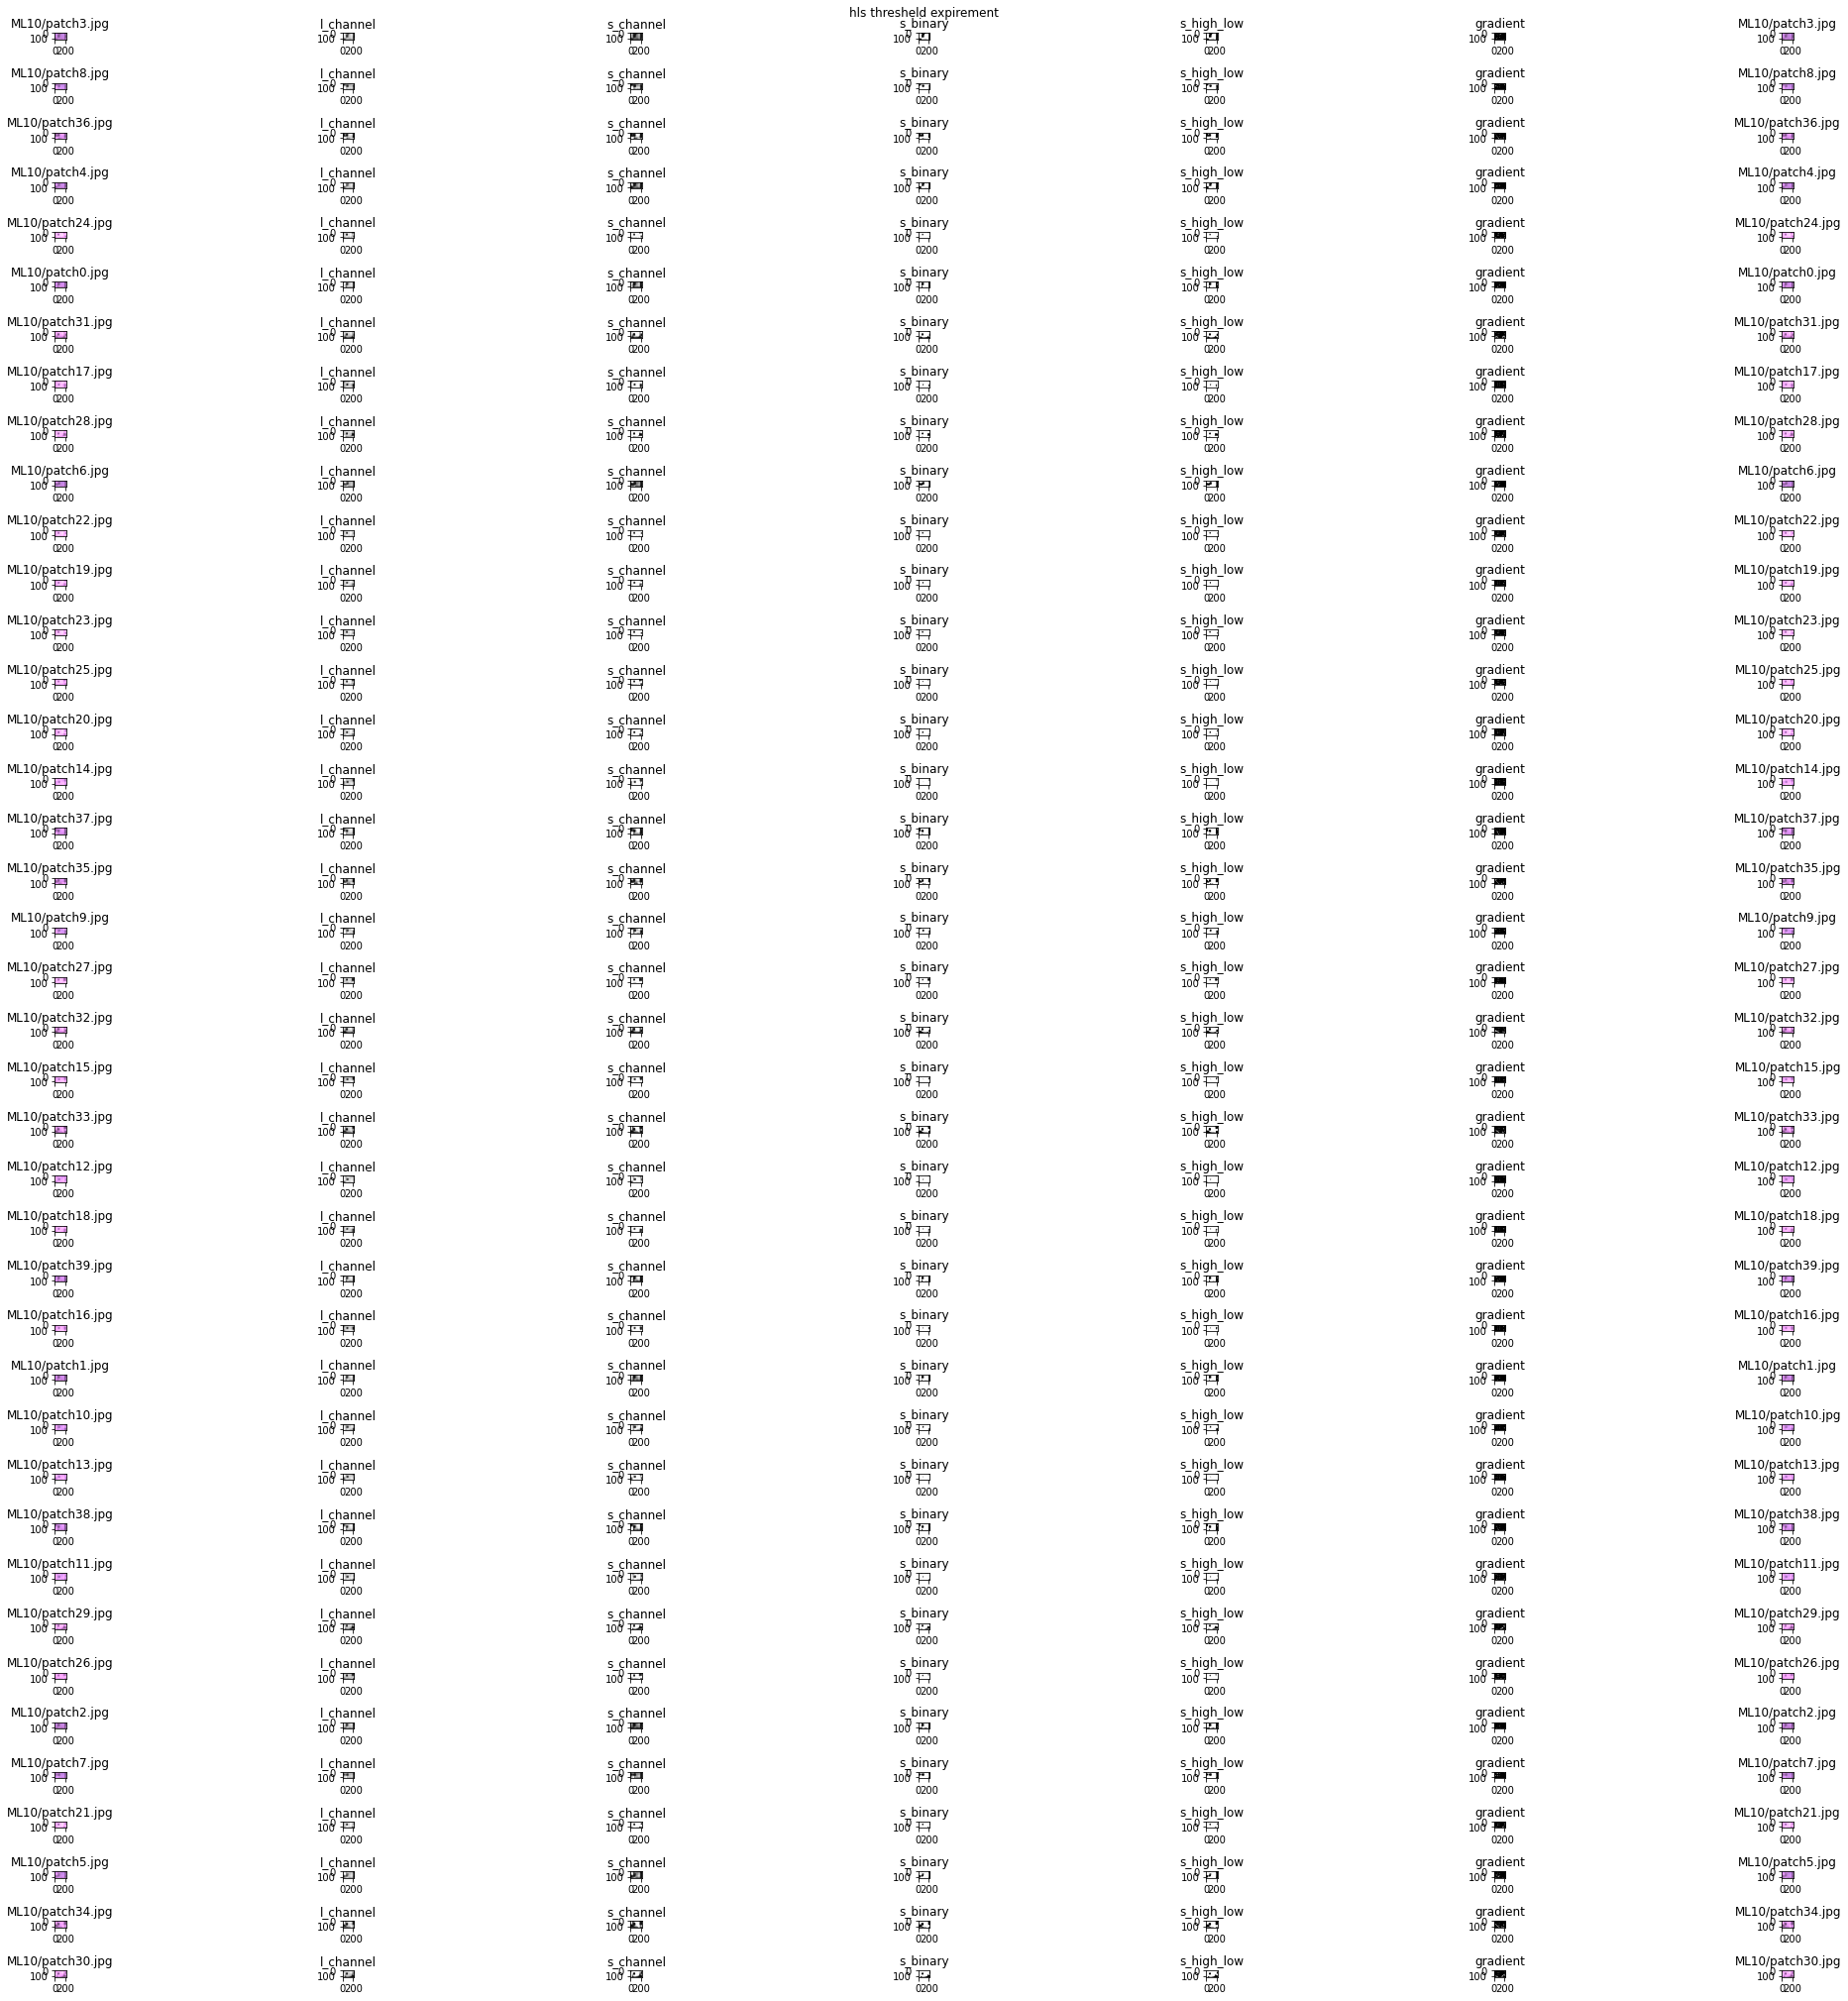

In [8]:
s_thresh = [90,255]
l_thresh = [30,200]

f, axes = plt.subplots(len(names),7,figsize=(30,28))
# plt.figure(figsize=(20,10))
for i in range(len(names)):
    img = mpimg.imread(names[i])
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary_zero = np.zeros_like(l_channel)
    l_binary_zero[l_channel>l_thresh[1]] = 1
    
    l_binary_one = np.ones_like(l_channel)
    l_binary_one[l_channel<l_thresh[0]] = 0
    
    s_high = np.zeros_like(l_channel)
    s_high[(s_binary==1) | (l_binary_zero==1)] = 1
    s_high_low = np.zeros_like(l_channel)
    s_high_low[(s_high==1) & (l_binary_one==1)] = 1
    
    axes[i][0].imshow(img)
    axes[i][0].set_title(names[i])
    
    axes[i][1].imshow(l_channel,cmap='gray')
    axes[i][1].set_title('l_channel')
    
    axes[i][2].imshow(s_channel,cmap='gray')
    axes[i][2].set_title('s_channel')
    
    axes[i][3].imshow(s_binary, cmap='gray')
    axes[i][3].set_title('s_binary')

    axes[i][4].imshow(s_high_low,cmap='gray')
    axes[i][4].set_title('s_high_low')
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gradient = get_gradient_thre(gray=gray)
    
    axes[i][5].imshow(gradient,cmap='gray')
    axes[i][5].set_title('gradient')
    
    axes[i][6].imshow(img)
    axes[i][6].set_title(names[i])
plt.tight_layout()
plt.suptitle('hls thresheld expirement',y=1)
plt.savefig('白地检测车道线阈值_30-200-90-255+gra.jpg',dpi=500)

## 确定hls最佳阈值为30-200-90-255
## 接下来确认gradient方法的阈值，目的在于减少无关像素的干扰

In [ ]:
f, axes = plt.subplots(len(names),8,figsize=(20,30))
# plt.figure(figsize=(20,10))
for i in range(len(names)):
    img = mpimg.imread(names[i])
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ker_size=3
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ker_size, thresh=(30, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ker_size, thresh=(30, 255))
    gradxy = np.zeros_like(gradx)
    gradxy[(gradx==1) & (grady==1)] = 1
    
    mag_bin = mag_thresh(gray, sobel_kernel=ker_size, mag_thresh=(70, 255))
    dir_bin = dir_thresh(gray, sobel_kernel=ker_size, dir_thresh=(0.7, 1.3))
    mag_dir = np.zeros_like(mag_bin)
    mag_dir[(mag_bin==1)&(dir_bin==1)]=1
    
    gradi_bi = np.zeros_like(mag_dir)
    gradi_bi[(gradxy==1)|(mag_dir==1)] = 1
    
    axes[i][0].imshow(img)
    axes[i][0].set_title(names[i])
    
    axes[i][1].imshow(gradxy,cmap='gray')
    axes[i][1].set_title('gradxy')
    
    axes[i][2].imshow(mag_bin,cmap='gray')
    axes[i][2].set_title('mag_bin')
    
    axes[i][3].imshow(mag_dir,cmap='gray')
    axes[i][3].set_title('mag_dir')
    
    axes[i][4].imshow(gradi_bi,cmap='gray')
    axes[i][4].set_title('gradient_binary')
    
    hls_bi = hls_select(img)
    axes[i][5].imshow(hls_bi,cmap='gray')
    axes[i][5].set_title('hls_select')
    
    result = np.zeros_like(gradi_bi)
    result[(gradi_bi==1)|(hls_bi)==1] = 1
    
    axes[i][6].imshow(result,cmap='gray')
    axes[i][6].set_title('result')
    
    axes[i][7].imshow(img)
    axes[i][7].set_title('source')
    
    
    
plt.tight_layout
plt.suptitle('gradient function debug',y=0.9)
plt.savefig('检测白地车道线实验30-255-70-255-0.7-1.3.jpg',dpi=500)

## 结论，阈值 50-255-70-255-0.7-1.3